# <span style="color:green"> Numerical Simulation Laboratory (NSL) </span>
## <span style="color:blue">  Numerical exercises 2</span>


### Exercise 02.1
- Compute the following 1D integral via Monte Carlo 
$$I = \int_0^1 \frac{\pi}{2}\cos(\pi x/2) dx = 1$$

1. sampling a uniform distribution in $[0,1]$
2. using importance sampling (i.e. sampling a non-uniform probability in $[0,1]$)

<span style="color:red">Show a picture of both your estimations of $I$</span> and their uncertainties with a large number of *throws* $M$ (e.g. $M\ge 10^4$) as a function of the number of blocks, $N$</font>.

## Importance Sampling

As seen in `Lezione_1/Esercizio_1_1`, the 1D Monte Carlo integral is sampled with a distribution $\rho(x)$, which in the first part of that exercise is the uniform distribution with $\rho(x) = 1 $ . Another approach is to use a distribution that resembles the function being integrated, which can reduce the variance and make the convergence process faster.

The procedure involves several steps:

1. **Taylor Expansion**  
   The first step is to perform a Taylor expansion of the function $f(x)$ around a point $x_0$:
   $$
   f(x) \approx f(x_0) + (x - x_0) \cdot \frac{d f(x)}{dx}| \Big{|} _{x = x_0} + \dots + o((x - x_0)^n)
   $$
   In particular, for this exercise, we consider the first-order Taylor expansion for the function $f(x) = \frac{\pi}{2} \cos\left(\frac{\pi x}{2}\right)$ evaluated at x = 1, which gives:
   $$
   f(x) \approx -\frac{\pi^2}{4}(x - 1)
   $$

2. **Normalization**  
   Next, it is normalized this expansion to ensure it represents a valid probability distribution:
   $$
   N = \int_0^1 -\frac{\pi^2}{4} (x - 1) \, dx = \frac{\pi}{8}
   $$
   This allows us to obtain the new sampling distribution function:
   $$
   \rho(x) = 2 - 2x
   $$

3. **Inverse Transform Sampling**  
   Using the inverse cumulative distribution function (CDF) method, it is possible to determine how to sample values of x from this distribution. Given the value $y$ sampled uniformly in $[0, 1]$, it is found $x$ as follows:
   $$
   x = 1 - \sqrt{1 - y}
   $$

4. **Importance Sampling**  
   With the new sampling method, it is applied importance sampling. By the property:
   $$
   \int_0^1 \frac{f(x)}{\rho(x)} \rho(x) \, dx = \int_0^1 f(x) \, dx
   $$
   It can draw numbers distributed according to $\rho(x)$ and then evaluate $\frac{f(x)}{\rho(x)}$ for the generated values. This allows to compute the integral with reduced variance.

**Observation:** The Taylor expansion was not carried out around x = 0 to second order, as it was not possible to calculate the inverse CDF for that case.


## Information about the Code

To evaluate the code, I created a virtual class in `.\Esercizio_2_1\FunzioneBase.hpp`, where I defined the `Eval()` method. This method allows the evaluation of functions that will be called in classes derived from the virtual class. Here, we can set parameters acting as additive or multiplicative factors, as in this example for the cosine function:

```cpp
class Coseno : public FunzioneBase {
public:
    Coseno() {a=1; b=1; c=1;};
    Coseno(double x, double y, double z) {a=x; b=y; c=z;};
    virtual ~Coseno() {;};
    virtual double Eval(double x) const { return a*cos(b*x)+c; }
    virtual double Val_max_ass() const { return a; } // returns the absolute value of the function in general

    void SetA(double x) {a=x;}
    void SetB(double y) {b=y;}
    void SetC(double z) {c=z;}

    double GetA() const {return a;}
    double GetB() const {return b;}
    double GetC() const {return c;}

private:
    double a, b, c;
};
```

Next, I created another class in `.\Esercizio_2_1\Integrali.hpp`, where I included the methods `Uniform` and `cos_important_sampling` to apply the sampling methods described earlier. Here’s an example for importance sampling of the cosine function:

```cpp
class cos_important_sampling : public Integral {
public:
    cos_important_sampling(double a, double b) : Integral(a, b) { ; }
    ~cos_important_sampling() { ; }

    virtual double Integra(unsigned int nstep, FunzioneBase &f, Random &rand) override {
        if (nstep < 1) {
            cout << "Negative step size" << endl;
            exit(-1);
        }
        double sum = 0;
        double x;

        for (unsigned int i = 0; i < nstep; i++) {
            x = sqrt(1 - rand.Rannyu()) + 1;  // Transforms for importance sampling
            sum += f.Eval(x) / (-2 * x + 2);  // Adjusts by probability density
        }

        // Calculates the integral using importance sampling adjustment
        m_integral = sum / nstep;
        return m_integral;
    }
};

```
In this example, it is possible to notice how the previously described method is used.
For this exercise, I used a number of throws equal to $M =10 ^4$ and a number of $N=100$ blocks to apply data blocking.
Below the results are shown:

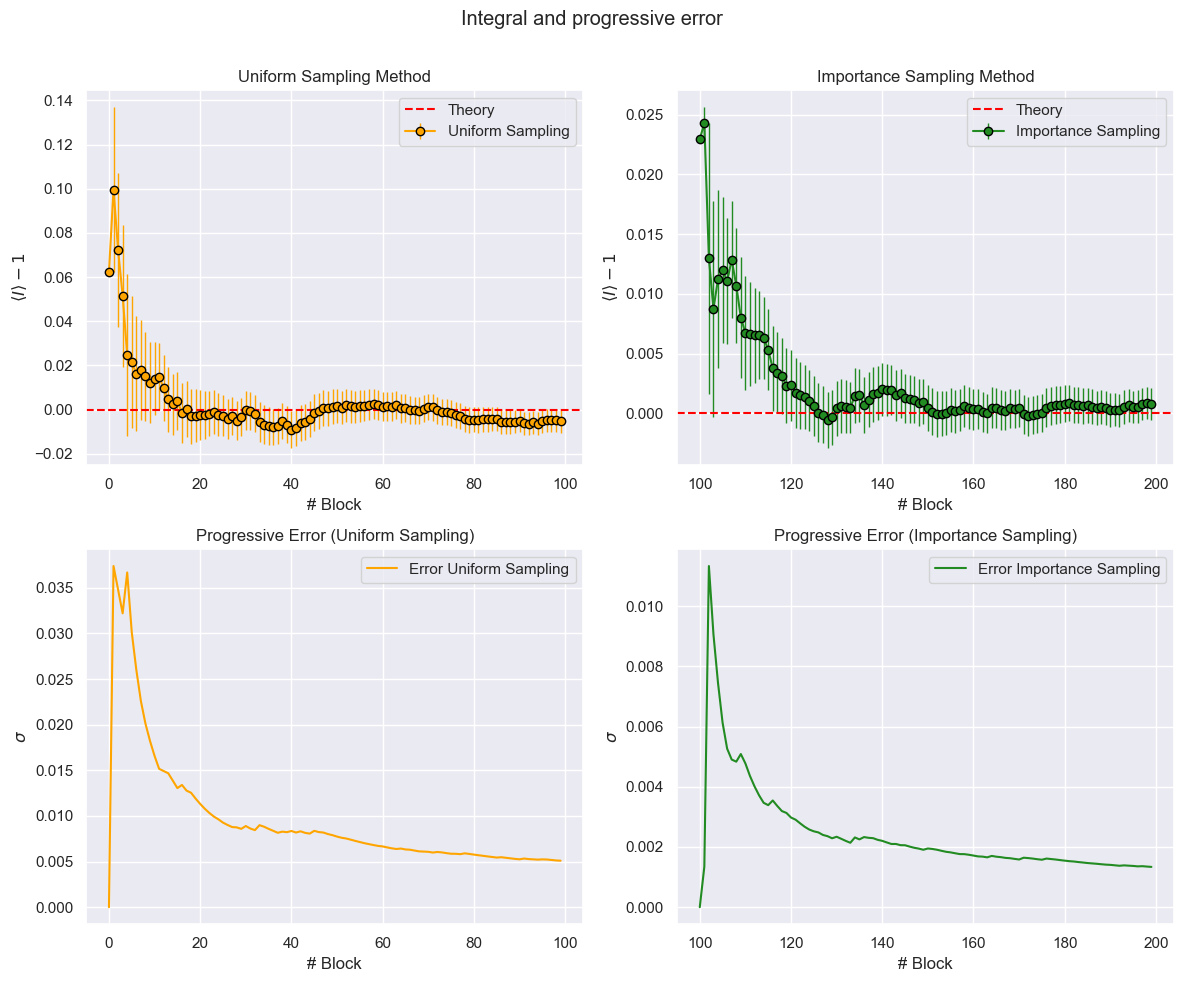

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set_theme(style="darkgrid")

# Load data
data_Unif = np.loadtxt('Esercizio_2_1/Integrale_uniforme.txt', usecols=(0, 1))
data_IS = np.loadtxt('Esercizio_2_1/Integrale_Importan_Sampling.txt', usecols=(0, 1))
media_Unif = data_Unif[:, 0]
errore_media_Unif = data_Unif[:, 1]

media_IS = data_IS[:, 0]
errore_media_IS = data_IS[:, 1]

# Set x-axis
x_unif = np.arange(len(media_Unif))
x_is = np.arange(len(media_IS)) + len(media_Unif)  # Shifted x for importance sampling

# Create subplots for integrals and errors
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Integral and progressive error')

# First graph - Uniform Integral values with error bars
ax1.errorbar(x_unif, media_Unif - 1, yerr=errore_media_Unif, marker='o', markeredgecolor='black',
             elinewidth=1, color='orange', label='Uniform Sampling')
ax1.axhline(0, ls='--', c='red', label='Theory')
ax1.set_title('Uniform Sampling Method')
ax1.set_xlabel('# Block')
ax1.set_ylabel(r'$\langle I \rangle - 1$')
ax1.grid(True)
ax1.legend()

# Second graph - Importance Sampling Integral values with error bars
ax2.errorbar(x_is, media_IS - 1, yerr=errore_media_IS, marker='o', markeredgecolor='black',
             elinewidth=1, color='forestgreen', label='Importance Sampling')
ax2.axhline(0, ls='--', c='red', label='Theory')
ax2.set_title('Importance Sampling Method')
ax2.set_xlabel('# Block')
ax2.set_ylabel(r'$\langle I \rangle - 1$')
ax2.grid(True)
ax2.legend()

# Third graph - Progressive error for Uniform Sampling
ax3.plot(x_unif, errore_media_Unif, color='orange', label='Error Uniform Sampling')
ax3.set_title('Progressive Error (Uniform Sampling)')
ax3.set_xlabel('# Block')
ax3.set_ylabel(r'$\sigma$')
ax3.grid(True)
ax3.legend()

# Fourth graph - Progressive error for Importance Sampling
ax4.plot(x_is, errore_media_IS, color='forestgreen', label='Error Importance Sampling')
ax4.set_title('Progressive Error (Importance Sampling)')
ax4.set_xlabel('# Block')
ax4.set_ylabel(r'$\sigma$')
ax4.grid(True)
ax4.legend()

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.9)  # Adjust top space to fit suptitle
plt.show()


## Discussions and Observations

In these graphs, it is evident that both methods tend to converge to the expected value as the number of blocks increases. However, it is noteworthy that the error reached by the uniform sampling method, $ \sigma \simeq 2 \cdot 10^{-3} $, is greater than that reached by the importance sampling method, $ \sigma \simeq 5 \cdot 10^{-3} $. 

The initial fluctuations are due to the blocking method being applied to a low number of blocks.


### Exercise 02.2
- <span style="color:red">3D Random Walks (RW) on a cubic lattice and in the continuum:</span> Repeat many times (e.g. say $10^4$) the simulation of a random walk in 3D always starting at the origin

1. on a cubic lattice with lattice constant $a=1$; at each discrete time the walker makes a forward or backward step of length equal to $a$ in one of the 3 principal directions of the lattice: $x$, $y$ or $z$
2. in the continuum; at each discrete time the walker makes a step of length equal to $a(=1)$ along a **random direction** obtained by sampling **uniformly** the solid angle: $\theta \in [0,\pi]$ and $\phi \in [0,2\pi]$

<span style="color:red">Show a picture of $\sqrt{\langle |\vec{r}_N|^2 \rangle_{RW}}$ for both RWs</span>, with their statistical uncertainties, as function of the step $i\in [0,10^2]$.

Suggestion: divide your $M$ throws into a reasonable number of blocks, compute $\sqrt{\langle |\vec{r}_N|^2 \rangle_{RW}}$ as function of the step $i\in [0,10^2]$ in each block and use these values (for fixed $i$) to obtain the average value and its statistical uncertainty.

Note that you could try to fit both results with a function like $f(N)=k\sqrt{N}$. Do your results indicate a diffusive behavior?

## Random Walk

The random walk is a fundamental stochastic process. Starting from an initial point, a random movement with step size $ a $ is executed, where the direction is chosen uniformly either in the continuum space or along one of the axes in a cubic lattice. This process is also illustrative because it exemplifies a Markov process, meaning that the movement does not depend on the history of previous steps.

It has several properties: firstly, the expected value of the random steps (the average of all possible steps) is zero if the direction is uniformly distributed. However, the second moment of this process exhibits diffusive behavior, as the error is proportional to the square root of the number of steps taken.

In summary, for a random walk, as far as the second moment that due to the mean $\langle |\vec{r}_N| \rangle = 0$ is equal to the variance $\sigma^2$:

$$
\langle |\vec{r}_N|^2 \rangle = a^2 N,
$$

which is independent on the dimensions. In particular, this process, which has a finite variance and satisfies the Central Limit Theorem, leading to a distribution in 1D given by

$$
p(x, t) \to \frac{1}{(2 \pi \sigma^2)^{1/2}} e^{-\frac{x^2}{2\sigma^2}},
$$

Here, $ \langle |\vec{r}_N|^2 \rangle $ is the mean squared distance, and $ N $ is the number of steps. The standard deviation of the final position is thus proportional to $ \sqrt{N} $, indicating a diffusive process.

### Diffusive Process

We show the calculation for a 1D random walk. If it is considered a diffusive process by definition, such a process must satisfy the equation:

$$
\frac{\partial p_1(\vec{x}, t)}{\partial t} = D \frac{\partial^2 p_1(x, t)}{\partial x^2},
$$

where $ D $ is the diffusion constant, $ p_1 $ is the probability density function, and $ t $ is the time between steps. Considerating as starting point $\rho(x,t=0)=\delta(x)$ By using the Fourier transform method, it is possible to obtain the probability:

$$
p_1(x,t) = \frac{1}{\sqrt{4Dt}} e^{-\frac{x^2}{4Dt}}.
$$

which is a distribution centered in x = 0 and has $\sigma^2 = 2Dt$.

This result is consistent with the previous findings. In fact, given that the time elapsed is $ t = N \tau $, where $\tau$ is a time step, and $
D = \frac{a^2}{2\tau}$ it is possible to arrive to equality $$\sigma^2 = Na^2  = 2D N \tau = 2Dt$$.

For a 3D random walk, it is slightly different in terms of constants and vectors, but the validity of the result does not change.

One of the aim of this exercise is to verify if this affermation is true.





## Random Walk in a Cubic Lattice

This exercise codes are in the folder `.\Esercizio_2_2`:

To create a random walk in a crystal, one must consider that only 6 movements are possible: the 3 directions of the axes $x, y, z$ in both senses. For this reason, I updated `random.cpp` by adding a method called `RW3D_discreto`, which updates the position of the initial point  $ \vec{x} $ by making a step of size $a =  1$ in one of the aforementioned directions, chosen uniformly. This method then returns a vector containing all the quadratic distances $|r_N|^2$ step by step from the initial point , which for this exercise is set to be the origin.

```cpp
    vector <double> Random::RW3D_discreto(unsigned int step) {
        // Extract uniformly a number between 0 and 6; the interval is divided into 6 parts, one for each movement in 3D
        // Return the final distance vector
        double x = 0;
        double y = 0;
        double z = 0;
    
        vector <double> RW;
        
        for (int i = 0; i < step; i++) {
            double s = Rannyu() * 6.;
            
            // Condition for x
            if (s < 1.) { x++; }
            if (s >= 1. && s < 2.) { x--; }
            // Condition for y
            if (s >= 2. && s < 3.) { y++; }
            if (s >= 3. && s < 4.) { y--; }
            // Condition for z
            if (s >= 4. && s < 5.) { z++; }
            if (s >= 5. && s < 6.) { z--; }
            
            RW.push_back(distanza_3D(x, y, z));
        }
     
        return RW;
    }
```
Subsequently, $10^5$ random walks of 100 steps each were collected into a matrix and divided into $10^2$ blocks, each containing $10^3$ random walks. For each block, the mean at each step was first calculated across the random walks within that block. Then, a progressive mean was calculated across all blocks to apply data blocking for computing the overall mean and error.

The graph is shown below:


Optimal k: 1.0000581949894307


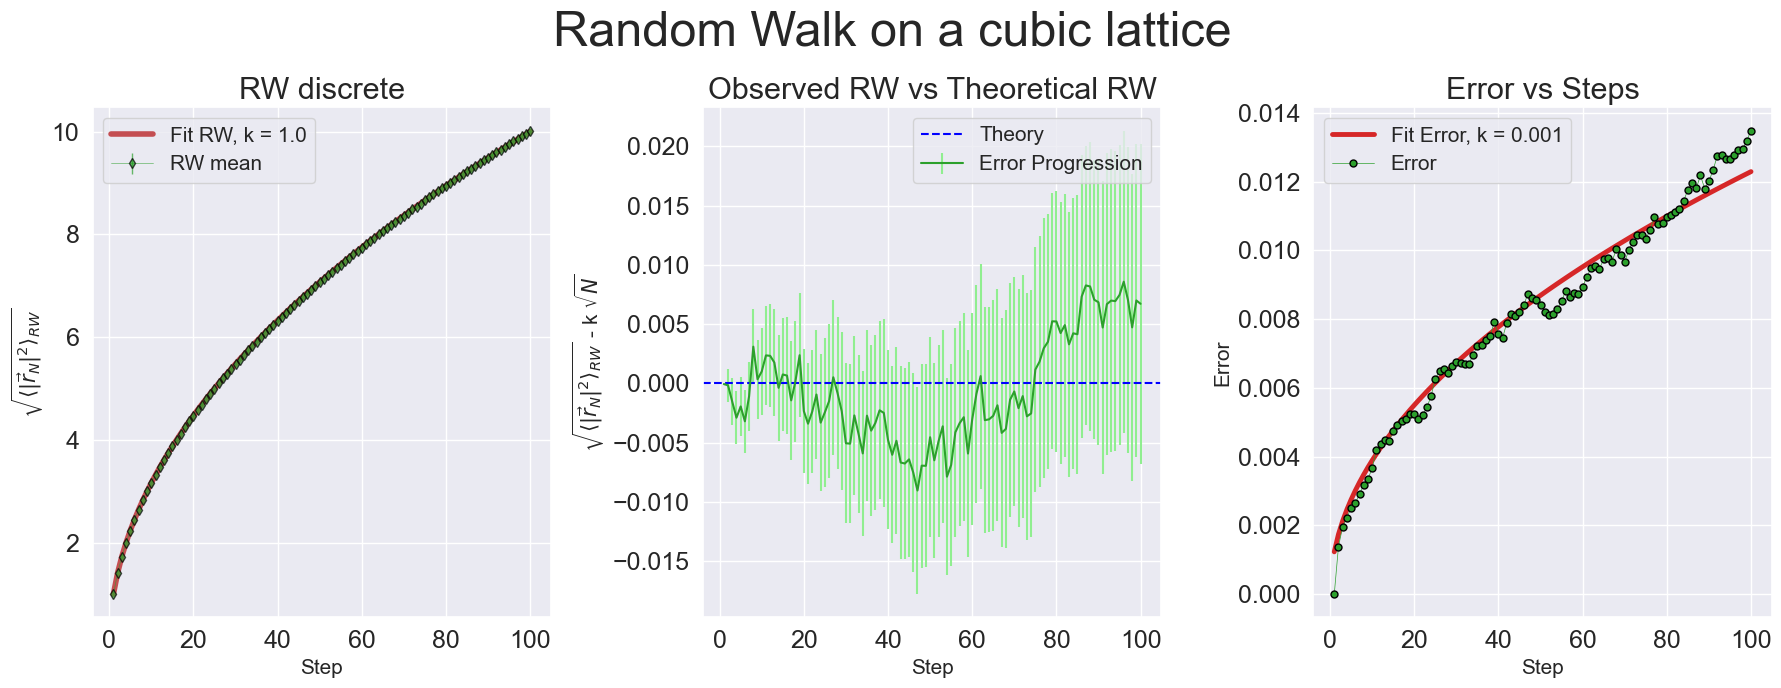

In [55]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
import seaborn as sns

sns.set_theme(style="darkgrid")

# Define the fitting function
def funzione(N, k):
    return k * np.sqrt(N)

# Load data
data_RW = np.loadtxt('Esercizio_2_2/RW3D_discreto.txt', usecols=(0, 1))
step = np.arange(1, 101, 1)

dist = data_RW[:, 0]
err = data_RW[:, 1]

# Perform curve fitting
parametri_ottimali, covarianza = curve_fit(funzione, step, dist)
k_ottimale = parametri_ottimali[0]

# Print optimal parameters
print("Optimal k:", k_ottimale)

# Create subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 7 ))
fig.suptitle('Random Walk on a cubic lattice', fontsize=35)

# First graph - Random Walk data and fit
ax1.plot(step, k_ottimale * np.sqrt(step), color="r", linestyle='-', 
         label='Fit RW, k = ' + str(np.round(k_ottimale, 3)), lw=4)
ax1.errorbar(step, dist, yerr=err, marker='d', markersize=5, elinewidth=1, 
             mec='black', linestyle='-', lw=0.5, color='tab:green', alpha=0.7, label='RW mean')

# Titles and labels for the first graph
ax1.set_title('RW discrete',fontsize = 22)
ax1.set_xlabel('Step',fontsize = 15)
ax1.set_ylabel(r'$\sqrt{\langle |\vec{r}_N|^2 \rangle_{RW}}$',fontsize = 15)
ax1.grid(True)
ax1.tick_params(axis='both', which='major', labelsize=18)  # Increase axis tick font size
ax1.legend(fontsize = 15)

# Second graph - Progressive Error
n_data_points = np.arange(1, len(dist) + 1)
ax2.errorbar(step, dist - k_ottimale * np.sqrt(step), yerr=err, color='tab:green', 
             ecolor='lightgreen', label='Error Progression')
ax2.set_title('Observed RW vs Theoretical RW',fontsize = 22)
ax2.set_xlabel('Step',fontsize = 15)
ax2.axhline(y=0, color='blue', linestyle='--', label='Theory')
ax2.set_ylabel(r'$\sqrt{\langle |\vec{r}_N|^2 \rangle_{RW}}$ - k $\sqrt{N}$',fontsize = 15)
ax2.grid(True)
ax2.tick_params(axis='both', which='major', labelsize=18)  # Increase axis tick font size
ax2.legend(fontsize = 15)

# Third graph - Error as a function of steps
ax3.errorbar(step, err, color='tab:green', marker='o', markersize=5, elinewidth=1, 
             mec='black', linestyle='-', lw=0.5, label='Error')

# Perform curve fitting for error
parametri_ottimali_err, covarianza_err = curve_fit(funzione, step, err)
k_ottimale_err = parametri_ottimali_err[0]

# Plot the fitted error curve
ax3.plot(step, k_ottimale_err * np.sqrt(step), color='tab:red', linestyle='-', 
         label='Fit Error, k = ' + str(np.round(k_ottimale_err, 3)), lw=3.5)

# Titles and labels for the third graph
ax3.set_title('Error vs Steps',fontsize = 22)
ax3.set_xlabel('Step',fontsize = 15)
ax3.set_ylabel('Error',fontsize = 15)
ax3.tick_params(axis='both', which='major', labelsize=18)  # Increase axis tick font size
ax3.grid(True)

ax3.legend(fontsize = 15)

# Display the plots
plt.tight_layout()
plt.show()


### Observation and Discussion:
In this graph, it is possible to observe how the system evolves in a diffusive manner with a fit constant $ k = 1.000 $. 

Moreover, the behavior of the error is also interesting; given its shape, it was decided to plot the same diffusive law, revealing that it follows the trend $ \sigma \propto k \sqrt{N_{\text{step}}} $ with $ k = 0.001 $. This could be an interesting point for further investigation.


## Random Walk in the Continuum

For the continuum, the program is pretty much the same except for the creation of data: a point is created uniformly on the unit sphere by the method `random_angle`, and then the positions are updated as previously:

```cpp
vector <double> Random :: RW3D_continuum (unsigned int step ){

   double x = 0;
   double y = 0;
   double z = 0;
   vector <double> RW;

   for (int i = 0; i < step; i++){
      
      double u = Rannyu(); // Uniformly distributed random number in [0, 1]
      double v = Rannyu(); // Uniformly distributed random number in [0, 1]
      
      double theta = acos(2 * u - 1); // Polar angle
      double phi = 2 * M_PI * v;      // Azimuthal angle
      
      x += sin(theta)*cos(phi);
      y += sin(theta)*sin(phi);
      z += cos(theta);
      
      RW.push_back(distanza_3D(x,y,z));
      
   }
   
   return (RW);
};
```
Again, $10^5$ random walks of 100 steps each were collected into a matrix that was divided internaly in 10^2 blocks.  For each block, the mean at each step was first calculated across the random walks within that block. Then, a progressive mean was calculated across all blocks to apply data blocking for computing the overall mean and error.

Below the graphic are shown:

Optimal k for RW: 0.9970856379930845


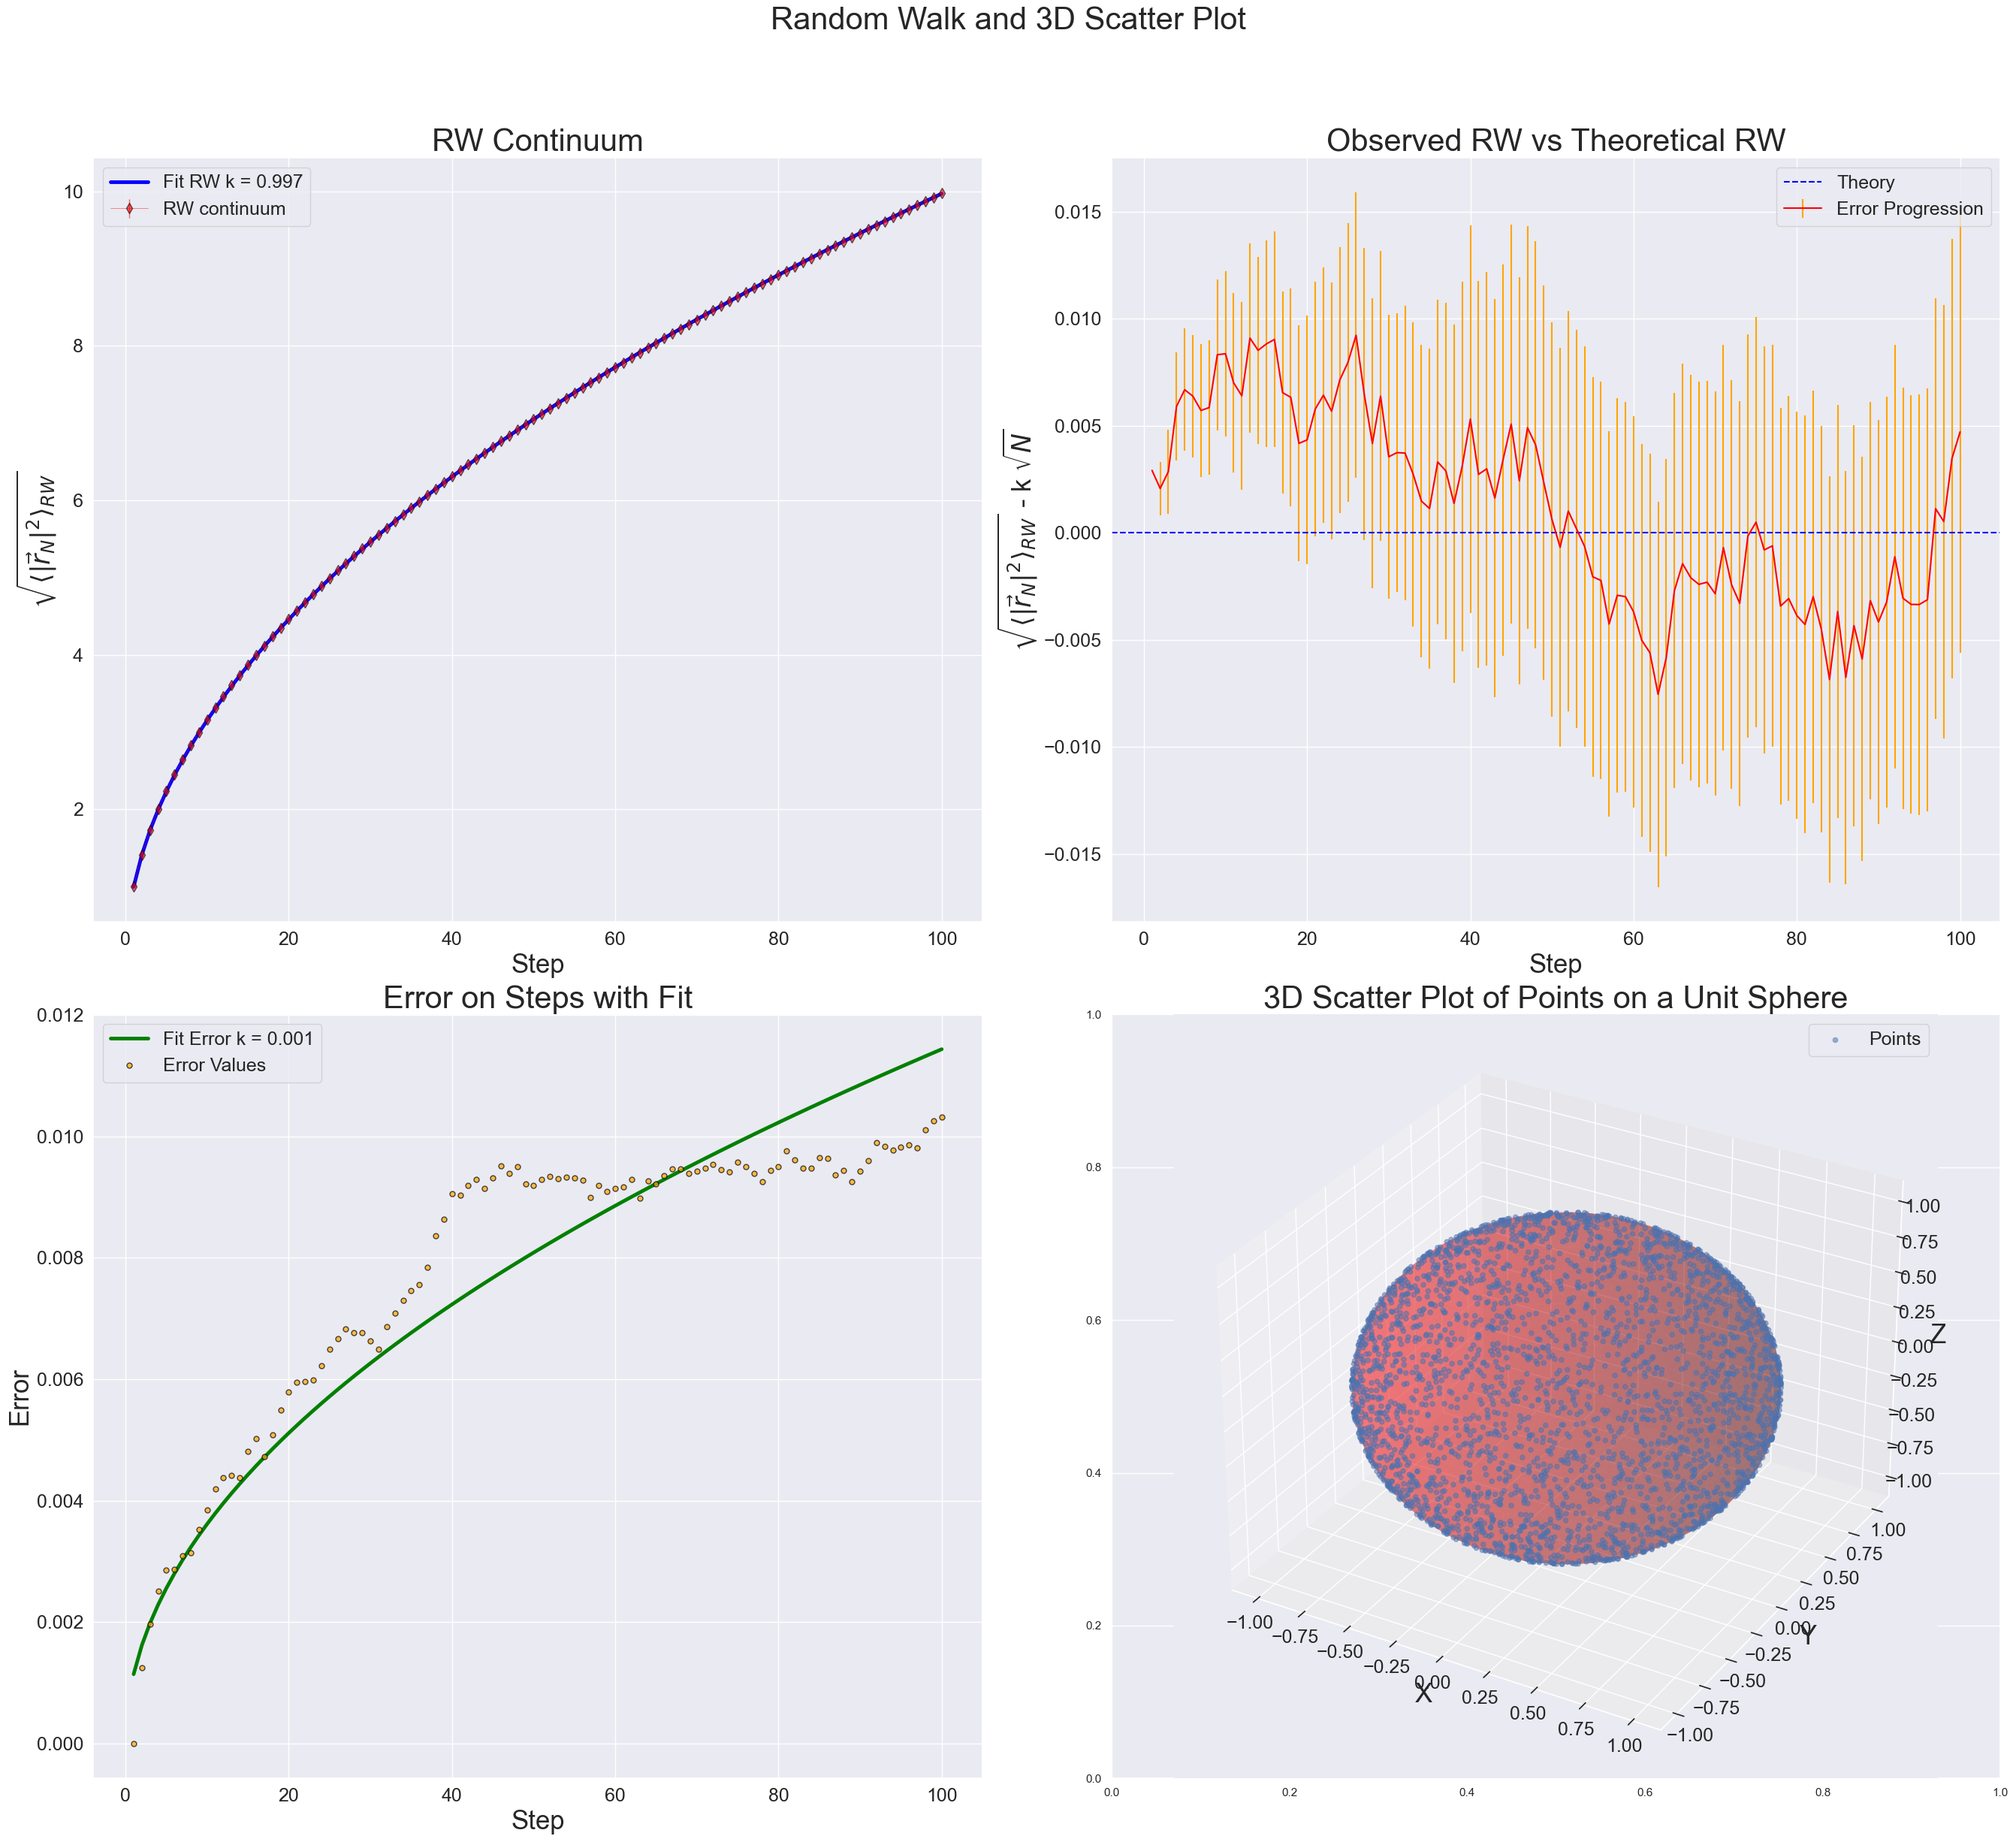

In [67]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

sns.set_theme(style="darkgrid")

# Define the fitting function
def funzione(N, k):
    return k * np.sqrt(N)

# Load data for Random Walk
data_RW = np.loadtxt('Esercizio_2_2/RW3D_continuo.txt', usecols=(0, 1))
step = np.arange(1, 101, 1)

dist = data_RW[:, 0]
err = data_RW[:, 1]

# Perform curve fitting for the first graph
parametri_ottimali, covarianza = curve_fit(funzione, step, dist)
k_ottimale = parametri_ottimali[0]

# Print optimal parameters
print("Optimal k for RW:", k_ottimale)

# Load data for 3D scatter plot
data = np.loadtxt('./Esercizio_2_2/angle_gen.dat', skiprows=0)
x = data[:3000, 0]
y = data[:3000, 1]
z = data[:3000, 2]

# Create a 2x2 subplot matrix
fig, ((ax1, ax2), (ax4, ax3)) = plt.subplots(2, 2, figsize=(27, 25))
fig.suptitle('Random Walk and 3D Scatter Plot', fontsize=30)

# First graph - Continuous Random Walk data and fit
ax1.errorbar(step, dist, yerr=err, marker='d', markersize=7, elinewidth=1, linestyle='-', 
             lw=0.5, color='red', alpha=0.6, markeredgecolor='black', label='RW continuum')
ax1.plot(step, k_ottimale * np.sqrt(step), color="blue", linestyle='-', 
         label='Fit RW k = ' + str(np.round(k_ottimale, 3)), lw=3.5)
ax1.set_title('RW Continuum', fontsize=30)
ax1.set_xlabel('Step', fontsize=25)
ax1.set_ylabel(r'$\sqrt{\langle |\vec{r}_N|^2 \rangle_{RW}}$', fontsize=25)
ax1.tick_params(axis='both', which='major', labelsize=18)  # Increase axis tick font size
ax1.grid(True)
ax1.legend(fontsize=18)

# Second graph - Progressive Error
n_data_points = np.arange(1, len(dist) + 1)
ax2.errorbar(n_data_points, dist - k_ottimale * np.sqrt(step), yerr=err, color='red', 
             markeredgecolor='black', ecolor='orange', label='Error Progression')
ax2.set_title('Observed RW vs Theoretical RW', fontsize=30)
ax2.set_xlabel('Step', fontsize=25)
ax2.set_ylabel(r'$\sqrt{\langle |\vec{r}_N|^2 \rangle_{RW}}$ - k $\sqrt{N}$', fontsize=25)
ax2.axhline(y=0, color='blue', linestyle='--', label='Theory')
ax2.tick_params(axis='both', which='major', labelsize=18)  # Increase axis tick font size
ax2.grid(True)
ax2.legend(fontsize=18)

# Third graph - Error on Steps with Fit 
# Fit the error data
parametri_errore, _ = curve_fit(funzione, step, err)
k_error = parametri_errore[0]

ax4.errorbar(step, err, marker='o', markersize=5, elinewidth=1, linestyle='', 
             color='orange', alpha=0.7, markeredgecolor='black', label='Error Values')
ax4.plot(step, k_error * np.sqrt(step), color="green", linestyle='-', 
         label='Fit Error k = ' + str(np.round(k_error, 3)), lw=3.5)
ax4.set_title('Error on Steps with Fit', fontsize=30)
ax4.set_xlabel('Step', fontsize=25)
ax4.set_ylabel('Error', fontsize=25)
ax4.tick_params(axis='both', which='major', labelsize=18)  # Increase axis tick font size
ax4.grid(True)
ax4.legend(fontsize=18)

# Fourth graph - 3D scatter plot 
ax3 = fig.add_subplot(224, projection='3d')  # Create a 3D subplot in position 2,2
ax3.scatter(x, y, z, color='b', alpha=0.5, marker='o', label='Points')
# Add a unit sphere for reference
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
x_sphere = np.outer(np.cos(u), np.sin(v))
y_sphere = np.outer(np.sin(u), np.sin(v))
z_sphere = np.outer(np.ones(np.size(u)), np.cos(v))
ax3.plot_surface(x_sphere, y_sphere, z_sphere, color='red', alpha=0.3, edgecolor='none')
ax3.set_xlabel('X', fontsize=25)
ax3.set_ylabel('Y', fontsize=25)
ax3.set_zlabel('Z', fontsize=25)
ax3.set_title('3D Scatter Plot of Points on a Unit Sphere', fontsize=30)
ax3.tick_params(axis='both', which='major', labelsize=18)  # Increase axis tick font size
ax3.legend(fontsize=18)

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.9)  # Adjust the top to make room for the suptitle

# Display the plots
plt.show()


### Observation and Discussion:
In this graph, it is possible to observe how the system evolves in a diffusive manner with a fit constant $ k = 0.997 $. 

Moreover, the behavior of the error is also interesting; given its shape, it was decided to plot the same diffusive law, revealing that it follows the trend $ \sigma \propto k \sqrt{N_{\text{step}}} $ with $ k = 0.001 $. This could be an interesting point for further investigation.

Additionally, a plot was added where the points are displayed to visualize a uniform sampling on a sphere with a radius of 1.

